In [1]:
import os
from os.path import join, exists, isfile, realpath, dirname
import argparse
from glob import glob
import random, shutil, json
from math import log10, ceil

import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from torch.utils.data.dataset import Subset

import faiss

import netvlad

import torch.optim as optim
from tensorboardX import SummaryWriter

from datetime import datetime
from os import makedirs, remove, chdir, environ

import matplotlib.pyplot as plt

import cv2

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
parser = argparse.ArgumentParser(description='pytorch-NetVlad')
parser.add_argument('--mode', type=str, default='train', help='Mode', choices=['train', 'test', 'cluster'])
parser.add_argument('--batchSize', type=int, default=4, help='Number of triplets (query, pos, negs). Each triplet consists of 12 images.')
parser.add_argument('--cacheBatchSize', type=int, default=24, help='Batch size for caching and testing')
parser.add_argument('--cacheRefreshRate', type=int, default=1000, help='How often to refresh cache, in number of queries. 0 for off')
parser.add_argument('--nEpochs', type=int, default=30, help='number of epochs to train for')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('--nGPU', type=int, default=1, help='number of GPU to use.')
parser.add_argument('--optim', type=str, default='SGD', help='optimizer to use', choices=['SGD', 'ADAM'])
parser.add_argument('--lr', type=float, default=0.0001, help='Learning Rate.')
parser.add_argument('--lrStep', type=float, default=5, help='Decay LR ever N steps.')
parser.add_argument('--lrGamma', type=float, default=0.5, help='Multiply LR by Gamma for decaying.')
parser.add_argument('--weightDecay', type=float, default=0.001, help='Weight decay for SGD.')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGD.')
parser.add_argument('--nocuda', action='store_true', help='Dont use cuda')
parser.add_argument('--threads', type=int, default=8, help='Number of threads for each data loader to use')
parser.add_argument('--seed', type=int, default=123, help='Random seed to use.')
parser.add_argument('--dataPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/data/', help='Path for centroid data.')
parser.add_argument('--runsPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', help='Path to save runs to.')
parser.add_argument('--savePath', type=str, default='checkpoints', help='Path to save checkpoints to in logdir. Default=checkpoints/')
parser.add_argument('--cachePath', type=str, default='/tmp', help='Path to save cache to.')
parser.add_argument('--resume', type=str, default='', help='Path to load checkpoint from, for resuming training or testing.')
parser.add_argument('--ckpt', type=str, default='latest', help='Resume from latest or best checkpoint.', choices=['latest', 'best'])
parser.add_argument('--evalEvery', type=int, default=1, help='Do a validation set run, and save, every N epochs.')
parser.add_argument('--patience', type=int, default=10, help='Patience for early stopping. 0 is off.')
parser.add_argument('--dataset', type=str, default='pittsburgh', help='Dataset to use', choices=['pittsburgh','naverlabs'])
parser.add_argument('--arch', type=str, default='vgg16', help='basenetwork to use', choices=['vgg16', 'alexnet'])
parser.add_argument('--vladv2', action='store_true', help='Use VLAD v2')
parser.add_argument('--pooling', type=str, default='netvlad', help='type of pooling to use', choices=['netvlad', 'max', 'avg'])
parser.add_argument('--num_clusters', type=int, default=64, help='Number of NetVlad clusters. Default=64')
parser.add_argument('--margin', type=float, default=0.1, help='Margin for triplet loss. Default=0.1')
parser.add_argument('--split', type=str, default='val', help='Data split to use for testing. Default is val', choices=['test', 'test250k', 'train', 'val'])
parser.add_argument('--fromscratch', action='store_true', help='Train from scratch rather than using pretrained models')

_StoreTrueAction(option_strings=['--fromscratch'], dest='fromscratch', nargs=0, const=True, default=False, type=None, choices=None, help='Train from scratch rather than using pretrained models', metavar=None)

In [4]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

from os.path import join, exists
from scipy.io import loadmat
import numpy as np
from collections import namedtuple
from PIL import Image

from sklearn.neighbors import NearestNeighbors
import h5py

root_dir = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/'
queries_dir = root_dir

def input_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])

def get_whole_training_set(onlyDB=False):
    return WholeDatasetFromStruct(input_transform=input_transform(), onlyDB=onlyDB, mode='train')

def get_training_query_set(margin=0.1):
    return QueryDatasetFromStruct(input_transform=input_transform(), margin=margin, mode='train')

def get_whole_val_set():
    return WholeDatasetFromStruct(input_transform=input_transform(), mode='val')

dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
                                   'db_image', 'db_utms', 'db_num', 'db_full_pose',
                                   'q_image', 'q_utms', 'q_num', 'q_full_pose',
                                   'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

class WholeDatasetFromStruct(data.Dataset):
    def __init__(self, input_transform=None, onlyDB=False, mode='train'):
        super().__init__()

        self.input_transform = input_transform

        self.dbStruct = my_parse_dbStruct(mode)
        self.images = [join(root_dir, dbIm) for dbIm in self.dbStruct.db_image]
        if not onlyDB:
            self.images += [join(queries_dir, qIm) for qIm in self.dbStruct.q_image]

        self.whichSet = self.dbStruct.whichSet
        self.dataset = self.dbStruct.dataset

        self.positives = None
        self.distances = None

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = img.resize((640, 480))

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

    def getPositives(self):
        # positives for evaluation are those within trivial threshold range
        #fit NN to find them, search by radius
        if  self.positives is None:
            knn = NearestNeighbors(n_jobs=-1)
            knn.fit(self.dbStruct.db_utms)

            self.distances, self.positives = knn.radius_neighbors(self.dbStruct.q_utms, radius=self.dbStruct.posDistThr)

        return self.positives

class QueryDatasetFromStruct(data.Dataset):
    def __init__(self, nNegSample=1000, nNeg=10, margin=0.1, input_transform=None, mode='train'):
        super().__init__()

        self.input_transform = input_transform
        self.margin = margin

        self.dbStruct = my_parse_dbStruct(mode)
        self.whichSet = self.dbStruct.whichSet
        self.dataset = self.dbStruct.dataset
        self.nNegSample = nNegSample # number of negatives to randomly sample
        self.nNeg = nNeg # number of negatives used for training

        # potential positives are those within nontrivial threshold range
        #fit NN to find them, search by radius
        knn = NearestNeighbors(n_jobs=-1)
        knn.fit(self.dbStruct.db_utms)

        # TODO use sqeuclidean as metric?
        self.nontrivial_positives = list(knn.radius_neighbors(self.dbStruct.q_utms,
                radius=self.dbStruct.nonTrivPosDistSqThr**0.5, 
                return_distance=False))
        # radius returns unsorted, sort once now so we dont have to later
        for i,posi in enumerate(self.nontrivial_positives):
            self.nontrivial_positives[i] = np.sort(posi)
        # its possible some queries don't have any non trivial potential positives
        # lets filter those out
        self.queries = np.where(np.array([len(x) for x in self.nontrivial_positives])>0)[0]

        # potential negatives are those outside of posDistThr range
        potential_positives = knn.radius_neighbors(self.dbStruct.q_utms,
                radius=self.dbStruct.posDistThr, 
                return_distance=False)

        self.potential_negatives = []
        for pos in potential_positives:
            self.potential_negatives.append(np.setdiff1d(np.arange(self.dbStruct.db_num),
                pos, assume_unique=True))

        self.cache = None # filepath of HDF5 containing feature vectors for images

        self.negCache = [np.empty((0,)) for _ in range(self.dbStruct.q_num)]

    def __getitem__(self, index):
        index = self.queries[index] # re-map index to match dataset
        with h5py.File(self.cache, mode='r') as h5: 
            h5feat = h5.get("features")

            qOffset = self.dbStruct.db_num 
            qFeat = h5feat[index+qOffset]

            posFeat = h5feat[self.nontrivial_positives[index].tolist()]
            knn = NearestNeighbors(n_jobs=-1) # TODO replace with faiss?
            knn.fit(posFeat)
            dPos, posNN = knn.kneighbors(qFeat.reshape(1,-1), 1)
            dPos = dPos.item()
            posIndex = self.nontrivial_positives[index][posNN[0]].item()

            negSample = np.random.choice(self.potential_negatives[index], self.nNegSample)
            negSample = np.unique(np.concatenate([self.negCache[index], negSample]))

            negFeat = h5feat[negSample.tolist()]
            knn.fit(negFeat)

            dNeg, negNN = knn.kneighbors(qFeat.reshape(1,-1), 
                    self.nNeg*10) # to quote netvlad paper code: 10x is hacky but fine
            dNeg = dNeg.reshape(-1)
            negNN = negNN.reshape(-1)

            # try to find negatives that are within margin, if there aren't any return none
            violatingNeg = dNeg < dPos + self.margin**0.5
     
            if np.sum(violatingNeg) < 1:
                #if none are violating then skip this query
                return None

            negNN = negNN[violatingNeg][:self.nNeg]
            negIndices = negSample[negNN].astype(np.int32)
            self.negCache[index] = negIndices

        query = Image.open(join(queries_dir, self.dbStruct.q_image[index]))
        query = query.resize((640, 480))
        positive = Image.open(join(root_dir, self.dbStruct.db_image[posIndex]))
        positive = positive.resize((640, 480))

        if self.input_transform:
            query = self.input_transform(query)
            positive = self.input_transform(positive)

        negatives = []
        for negIndex in negIndices:
            negative = Image.open(join(root_dir, self.dbStruct.db_image[negIndex]))
            negative = negative.resize((640, 480))
            if self.input_transform:
                negative = self.input_transform(negative)
            negatives.append(negative)

        negatives = torch.stack(negatives, 0)

        return query, positive, negatives, [index, posIndex]+negIndices.tolist()

    def __len__(self):
        return len(self.queries)

In [5]:
def my_parse_dbStruct(_whichSet='train'):

    whichSet = _whichSet
    dataset = 'naverlabs'
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images'
    image_files_list = []
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970285_*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970286_*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970288_*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970289_*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970290_*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970291_*.jpg'))))
    image_files = np.hstack(image_files_list)
    
    full_images = [os.path.join('images', image_file.split('/')[-1]) for image_file in image_files]
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/groundtruth.hdf5'

    full_pose = []
    with h5py.File(gt_path, "r") as f:
        full_pose.append(np.array(f['22970285_pose']))
        full_pose.append(np.array(f['22970286_pose']))
        full_pose.append(np.array(f['22970288_pose']))
        full_pose.append(np.array(f['22970289_pose']))
        full_pose.append(np.array(f['22970290_pose']))
        full_pose.append(np.array(f['22970291_pose']))   
        full_pose = np.vstack(full_pose)
    
    full_utms = full_pose[:,:2]
    
    db_image = full_images[:10000]
    db_utms = full_utms[:10000]
    db_num = len(db_image)
    db_full_pose = full_pose[:10000]
    
    q_image = full_images[10000:]
    q_utms = full_utms[:10000]
    q_num = len(q_image)
    q_full_pose = full_pose[10000:]
    

    return dbStruct(whichSet, dataset, 
                    db_image, db_utms, db_num, db_full_pose,
                    q_image, q_utms, q_num, q_full_pose, 
                    5, 25, 20.0)

# dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
#                                    'db_image', 'db_utms', 'db_num', 'db_full_pose',
#                                    'q_image', 'q_utms', 'q_num', 'q_full_pose',
#                                    'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

In [6]:
opt = parser.parse_args(args='--dataset=naverlabs --mode=test --resume=runs/May20_23-12-21_vgg16_netvlad --split=test'.split(' '))
restore_var = ['lr', 'lrStep', 'lrGamma', 'weightDecay', 'momentum', 
            'runsPath', 'savePath', 'arch', 'num_clusters', 'pooling', 'optim',
            'margin', 'seed', 'patience']

In [7]:
flag_file = join(opt.resume, 'checkpoints', 'flags.json')
if exists(flag_file):
    with open(flag_file, 'r') as f:
        stored_flags = {'--'+k : str(v) for k,v in json.load(f).items() if k in restore_var}
        to_del = []
        for flag, val in stored_flags.items():
            for act in parser._actions:
                if act.dest == flag[2:]:
                    # store_true / store_false args don't accept arguments, filter these 
                    if type(act.const) == type(True):
                        if val == str(act.default):
                            to_del.append(flag)
                        else:
                            stored_flags[flag] = ''
        for flag in to_del: del stored_flags[flag]

        train_flags = [x for x in list(sum(stored_flags.items(), tuple())) if len(x) > 0]
        print('Restored flags:', train_flags)
        opt = parser.parse_args(train_flags, namespace=opt)

Restored flags: ['--optim', 'SGD', '--lr', '0.0001', '--lrStep', '5', '--lrGamma', '0.5', '--weightDecay', '0.001', '--momentum', '0.9', '--seed', '123', '--runsPath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/', '--savePath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/May20_23-12-21_vgg16_netvlad/checkpoints', '--patience', '10', '--arch', 'vgg16', '--pooling', 'netvlad', '--num_clusters', '64', '--margin', '0.1']


In [8]:
print(opt)

Namespace(arch='vgg16', batchSize=4, cacheBatchSize=24, cachePath='/tmp', cacheRefreshRate=1000, ckpt='latest', dataPath='/home/ubuntu/Desktop/pytorch-NetVlad/data/', dataset='naverlabs', evalEvery=1, fromscratch=False, lr=0.0001, lrGamma=0.5, lrStep=5.0, margin=0.1, mode='test', momentum=0.9, nEpochs=30, nGPU=1, nocuda=False, num_clusters=64, optim='SGD', patience=10, pooling='netvlad', resume='runs/May20_23-12-21_vgg16_netvlad', runsPath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', savePath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/May20_23-12-21_vgg16_netvlad/checkpoints', seed=123, split='test', start_epoch=0, threads=8, vladv2=False, weightDecay=0.001)


In [9]:
cuda = not opt.nocuda
device = torch.device("cuda" if cuda else "cpu")

random.seed(opt.seed)
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)

In [10]:
whole_test_set = get_whole_val_set()
print('===> Evaluating on val set')

===> Evaluating on val set


In [11]:
pretrained = not opt.fromscratch

In [12]:
encoder_dim = 512
encoder = models.vgg16(pretrained=pretrained)
# capture only feature part and remove last relu and maxpool
layers = list(encoder.features.children())[:-2]

if pretrained:
    # if using pretrained then only train conv5_1, conv5_2, and conv5_3
    for l in layers[:-5]: 
        for p in l.parameters():
            p.requires_grad = False

In [13]:
encoder = nn.Sequential(*layers)
model = nn.Module() 
model.add_module('encoder', encoder)

In [14]:
net_vlad = netvlad.NetVLAD(num_clusters=opt.num_clusters, dim=encoder_dim, vladv2=opt.vladv2)
if not opt.resume: 
    if opt.mode.lower() == 'train':
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + train_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')
    else:
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + whole_test_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')

    if not exists(initcache):
        raise FileNotFoundError('Could not find clusters, please run with --mode=cluster before proceeding')

    with h5py.File(initcache, mode='r') as h5: 
        clsts = h5.get("centroids")[...]
        traindescs = h5.get("descriptors")[...]
        net_vlad.init_params(clsts, traindescs) 
        del clsts, traindescs

model.add_module('pool', net_vlad)

In [15]:
if opt.ckpt.lower() == 'latest':
    resume_ckpt = join(opt.resume, 'checkpoints', 'checkpoint.pth.tar')
elif opt.ckpt.lower() == 'best':
    resume_ckpt = join(opt.resume, 'checkpoints', 'model_best.pth.tar')

if isfile(resume_ckpt):
    print("=> loading checkpoint '{}'".format(resume_ckpt))
    checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
    opt.start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_score']
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    if opt.mode == 'train':
        optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume_ckpt, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_ckpt))

=> loading checkpoint 'runs/May20_23-12-21_vgg16_netvlad/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'runs/May20_23-12-21_vgg16_netvlad/checkpoints/checkpoint.pth.tar' (epoch 30)


# verify by the visualization

In [16]:
eval_set = whole_test_set
test_data_loader = DataLoader(dataset=eval_set, num_workers=opt.threads, batch_size=opt.cacheBatchSize, shuffle=False, pin_memory=cuda)

In [17]:
model.eval()
with torch.no_grad():
    print('====> Extracting Features')
    pool_size = encoder_dim
    if opt.pooling.lower() == 'netvlad': pool_size *= opt.num_clusters
    dbFeat = np.empty((len(eval_set), pool_size))

    for iteration, (input, indices) in enumerate(test_data_loader, 1):
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 

        dbFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(test_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, len(test_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding
del test_data_loader

====> Extracting Features
==> Batch (50/677)
==> Batch (100/677)
==> Batch (150/677)
==> Batch (200/677)
==> Batch (250/677)
==> Batch (300/677)
==> Batch (350/677)
==> Batch (400/677)
==> Batch (450/677)
==> Batch (500/677)
==> Batch (550/677)
==> Batch (600/677)
==> Batch (650/677)


In [18]:
# extracted for both db and query, now split in own sets
qFeat = dbFeat[eval_set.dbStruct.db_num:].astype('float32')
dbFeat = dbFeat[:eval_set.dbStruct.db_num].astype('float32')

print('====> Building faiss index')
faiss_index = faiss.IndexFlatL2(pool_size)
faiss_index.add(dbFeat)

print('====> Calculating recall @ N')
n_values = [1,5,10,20]

_, predictions = faiss_index.search(qFeat, max(n_values)) 

====> Building faiss index
====> Calculating recall @ N


In [19]:
image_data_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/'

# Place Recognition

In [20]:
def placeRecognition(query_idx, rank=0):
    plt.figure()
    query_image_full_path = os.path.join(image_data_path, eval_set.dbStruct.q_image[query_idx])
#     print(query_image_full_path)
    query_img = Image.open(query_image_full_path)
    plt.imshow(query_img)
    query_pose = eval_set.dbStruct.q_full_pose[query_idx]
#     print(query_pose)

    plt.figure()
    pred_image_full_path = os.path.join(image_data_path, eval_set.dbStruct.db_image[predictions[query_idx][rank]])
#     print(pred_image_full_path)
    pred_img = Image.open(pred_image_full_path) 
    plt.imshow(pred_img)
    pred_pose = eval_set.dbStruct.db_full_pose[predictions[query_idx][rank]]
#     print(pred_pose)
    
    return query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose

# Lidar map projection

In [21]:
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [263]:
A = np.array([[1725.842032333, 0.0, 1024.0],
              [0.0, 1725.842032333, 768.0],
              [0.0, 0.0, 1.0]])

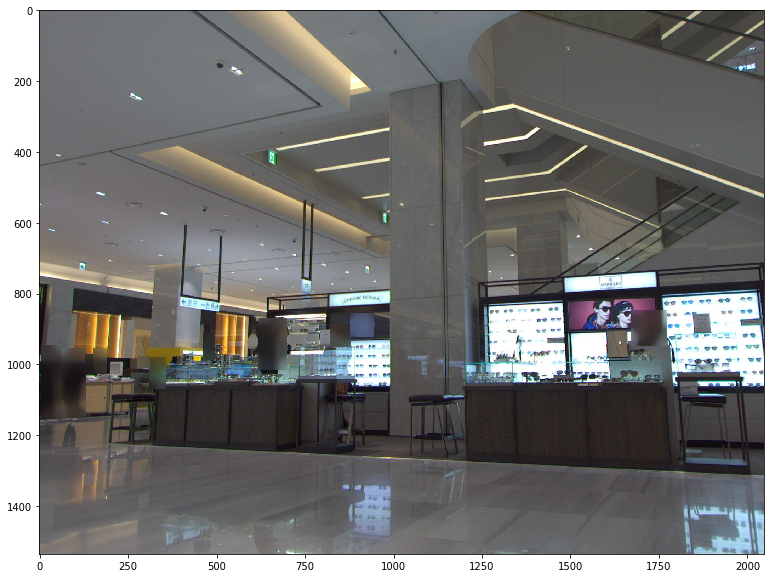

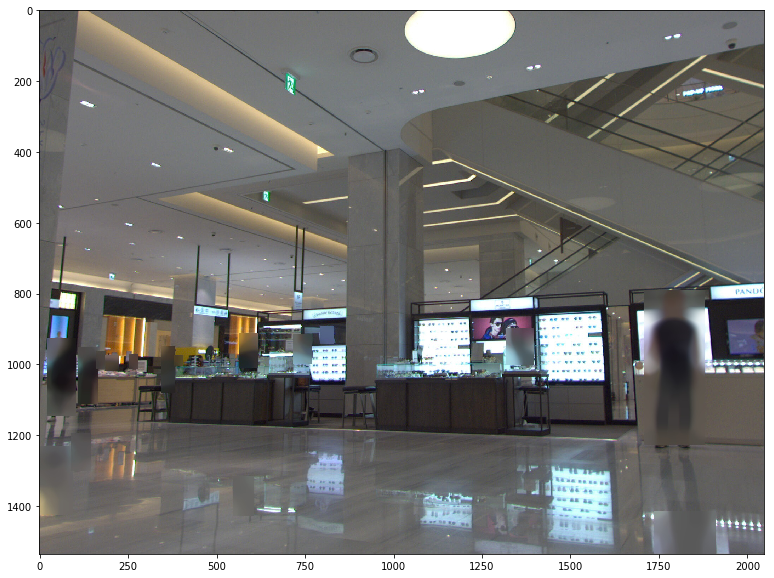

In [513]:
query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose = placeRecognition(600)

In [514]:
# VERY TIME CONSUMING!
# pcd = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/map.pcd")
# pcd_tree = o3d.geometry.KDTreeFlann(pcd)

In [519]:
[k, idx, _] = pcd_tree.search_radius_vector_3d(pred_pose[:3], 15.0)
print('the number of neighbors: ', k)

the number of neighbors:  10111901


In [520]:
def projection(img, _points, _A, _Rt, thickness=1):
    projected_img = np.ones_like(img)*np.inf
    agumented_points = np.c_[_points,np.ones(_points.shape[0])]
    transformed_points = np.linalg.inv(_Rt)@np.transpose(agumented_points)
    projected_points = _A@transformed_points[:3,:]
    hnormalized_points = projected_points/projected_points[2,:]      
    
    for i, hnormalized_point in enumerate(np.transpose(hnormalized_points)):  
        t_y = int(hnormalized_point[1])
        t_x = int(hnormalized_point[0])
        
        if (0 <= t_x and t_x < img.size[0] and 0 <= t_y and t_y < img.size[1]):
            pre_val = projected_img[t_y, t_x]
            new_val = transformed_points[:3,i]
        
            if (0 < new_val[2] and new_val[2] < pre_val[2]):
                projected_img[t_y-thickness:t_y+thickness, t_x-thickness:t_x+thickness] = new_val

    return projected_img

In [521]:
pred_Rt = np.eye(4)
pred_Rt[:3,3] = pred_pose[:3]
(pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()

GT_Rt = np.eye(4)
GT_Rt[:3,3] = query_pose[:3]
(GT_qw, GT_qx, GT_qy, GT_qz) = query_pose[3:]
GT_Rt[:3,:3] = R.from_quat([GT_qx,GT_qy,GT_qz,GT_qw]).as_matrix()

radius_points = np.asarray(pcd.points)[idx] 
pred_projected_img = projection(pred_img, radius_points, A, pred_Rt, thickness=3)
# pred_blended_img = cv2.addWeighted(pred_projected_img[:,:,2], 0.5, np.asarray(pred_img)[:,:,0], 1, 0)

GT_projected_img = projection(query_img, radius_points, A, GT_Rt, thickness=3)
# GT_blended_img = cv2.addWeighted(GT_projected_img[:,:,2], 0.5, np.asarray(query_img)[:,:,0], 1, 0)

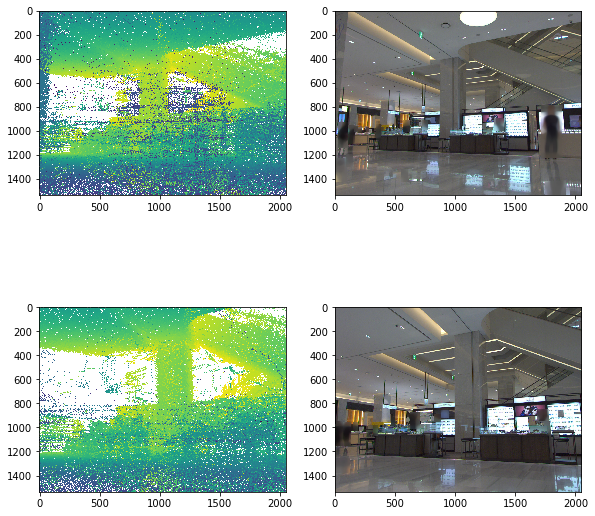

In [522]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(pred_projected_img[:,:,2])
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(pred_img)
# ax3 = fig.add_subplot(2, 3, 3)
# ax3.imshow(pred_blended_img)

ax5 = fig.add_subplot(2, 3, 4)
ax5.imshow(GT_projected_img[:,:,2])
ax4 = fig.add_subplot(2, 3, 5)
ax4.imshow(query_img)
# ax6 = fig.add_subplot(2, 3, 6)
# ax6.imshow(GT_blended_img)

plt.show()

# Superpoint feature extraction and matching

In [523]:
import os
import sys
sys.path.append("/home/ubuntu/Desktop/SuperPoint-VO/")

In [524]:
import numpy as np
import cv2

from sp_extractor import SuperPointFrontend, PointTracker
from norm_visual_odometry import PinholeCamera, VisualOdometry

import matplotlib.pyplot as plt

In [525]:
class SP_VisualOdometry:
    def __init__(self, cam):
        self.frame_stage = 0
        self.cam = cam
        self.new_frame = None
        self.last_frame = None
        self.cur_R = None
        self.cur_t = None
        self.px_ref = None
        self.px_cur = None
        self.focal = cam.fx
        self.pp = (cam.cx, cam.cy)
        self.trueX, self.trueY, self.trueZ = 0, 0, 0
        self.detector = SuperPointFrontend(weights_path="/home/ubuntu/Desktop/SuperPoint-VO/weights/superpoint_v1.pth",
                                           nms_dist=4,
                                           conf_thresh=0.015,
                                           nn_thresh=0.7,
                                           cuda=True)
        self.tracker = PointTracker(max_length=2, nn_thresh=self.detector.nn_thresh)

    def featureTracking(self, new_frame):
        pts, desc, heatmap = self.detector.run(new_frame)
        # Add points and descriptors to the tracker.
        self.tracker.update(pts, desc)
        # Get tracks for points which were match successfully across all frames.
        tracks = self.tracker.get_tracks(min_length=1)
        # Normalize track scores to [0,1].
        tracks[:, 1] /= float(self.detector.nn_thresh)
        kp1, kp2 = self.tracker.draw_tracks(tracks)
        return kp1, kp2

In [526]:
cam_param = PinholeCamera(2048, 1536, 1725.842032333, 1725.842032333, 1024.0, 768.0)
sp_vo = SP_VisualOdometry(cam_param)

In [527]:
query_img_sp = cv2.imread(query_image_full_path)
pred_img_sp = cv2.imread(pred_image_full_path)

In [528]:
sp_vo.featureTracking(query_img_sp)
px_query, px_pred = sp_vo.featureTracking(pred_img_sp)
curr_size = px_pred.shape[0]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


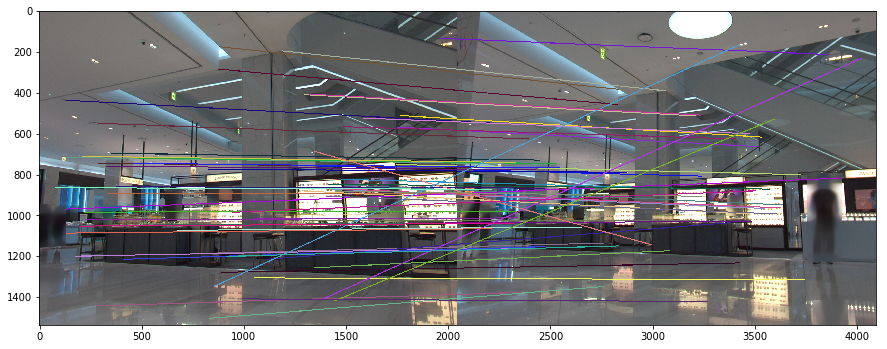

In [529]:
corr_img = np.hstack([query_img_sp, pred_img_sp])
for corr_idx in range(curr_size):
    if (corr_idx % 10 == 0):
        corr_img = cv2.line(corr_img, 
                            (px_query[corr_idx][0],px_query[corr_idx][1]), 
                            (pred_img_sp.shape[1]+px_pred[corr_idx][0], px_pred[corr_idx][1]), 
                            (np.random.randint(255),np.random.randint(255),np.random.randint(255)), 3)
plt.figure()
plt.imshow(corr_img)

In [530]:
points_2d = []
points_3d = []
for corr_idx in range(curr_size):
    if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
        points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
        points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])
        
points_2d = np.asarray(points_2d, dtype=np.float32)
points_3d = np.asarray(points_3d, dtype=np.float32)

In [531]:
retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, A, (0,0,0,0))
print(retval)
print(tvec)
print(rvec)

True
[[ 0.43296453]
 [-1.0637859 ]
 [-2.90219987]]
[[-0.04996654]
 [ 0.03738391]
 [-0.00316537]]


In [532]:
rotation_matrix = np.zeros(shape=(3,3))
cv2.Rodrigues(rvec, rotation_matrix)
print(rotation_matrix)

[[ 0.99929644  0.00222964  0.03743865]
 [-0.00409697  0.99874707  0.04987489]
 [-0.03728054 -0.04999318  0.99805353]]


In [533]:
query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]

query_Rt = np.eye(4)
query_Rt[:3,:3] = query_rot
query_Rt[:3,3] = query_trans

In [534]:
query_projected_img = projection(query_img, radius_points, A, query_Rt, thickness=3)

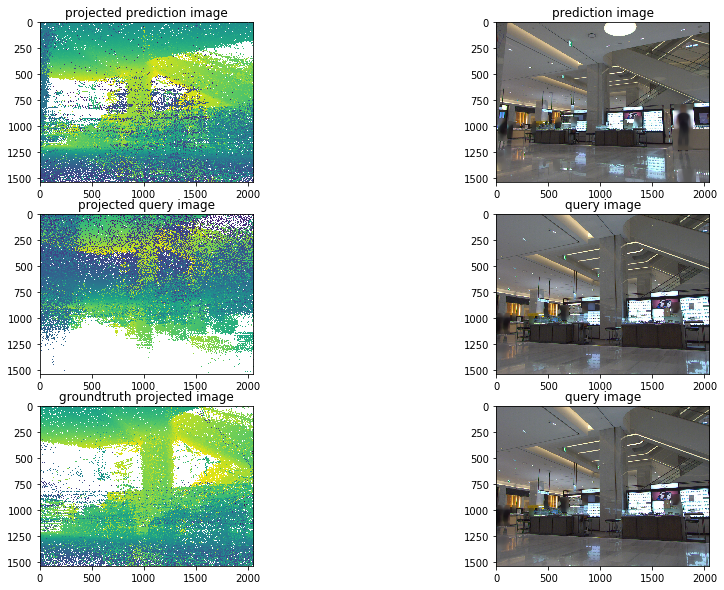

In [535]:
fig = plt.figure()

ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(pred_projected_img[:,:,2])
ax1.title.set_text('projected prediction image')
ax2 = fig.add_subplot(3, 2, 2)
ax2.imshow(pred_img)
ax2.title.set_text('prediction image')

ax3 = fig.add_subplot(3, 2, 3)
ax3.imshow(query_projected_img[:,:,2])
ax3.title.set_text('projected query image')
ax4 = fig.add_subplot(3, 2, 4)
ax4.imshow(query_img)
ax4.title.set_text('query image')

ax5 = fig.add_subplot(3, 2, 5)
ax5.imshow(GT_projected_img[:,:,2])
ax5.title.set_text('groundtruth projected image')
ax6 = fig.add_subplot(3, 2, 6)
ax6.imshow(query_img)
ax6.title.set_text('query image')
plt.show()

In [536]:
import pyquaternion as pyq
import math

# Create a hypothetical orientation of the upper leg and lower leg
# We use the (axis, degrees) notation because it's the most intuitive here
# Upper leg perfectly vertical with a slight rotation
query_quat = R.from_matrix(query_rot).as_quat()
q_query = pyq.Quaternion(query_quat[3],query_quat[0],query_quat[1],query_quat[2])
# Lower leg a little off-vertical, with a rotation in the other direction.
q_GT = pyq.Quaternion(GT_qw,GT_qx,GT_qy,GT_qz)

# Get the 3D difference between these two orientations
qd = q_GT.conjugate * q_query

# Calculate Euler angles from this difference quaternion
phi   = math.atan2( 2 * (qd.w * qd.x + qd.y * qd.z), 1 - 2 * (qd.x**2 + qd.y**2) )
theta = math.asin ( 2 * (qd.w * qd.y - qd.z * qd.x) )
psi   = math.atan2( 2 * (qd.w * qd.z + qd.x * qd.y), 1 - 2 * (qd.y**2 + qd.z**2) )

print(phi* 180 / 3.141592, theta* 180 / 3.141592, psi* 180 / 3.141592)

3.1615660146627396 -3.0995298020824227 0.4312828305485315


In [537]:
np.linalg.norm(query_trans- query_pose[:3])

5.381483870487924